In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import json
import ast
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from xgboost import XGBClassifier
import shap

In [2]:
# Load data
data = pd.read_csv("data_2002_2024.csv")
data

,team,season,week,total_yards,def_yards_allowed,turnovers,possession_time,pass_yards,rush_yards,third_down_pct,redzone_pct,point_diff,ypp,result,is_champion
0,49ers,2002,17,329,263,2,2137,136,193,0.428571,0.000000,-11,5.222222,0,0
1,49ers,2002,16,358,184,2,2059,252,106,0.550000,0.000000,3,4.904110,1,0
2,49ers,2002,15,263,302,1,1437,156,107,0.461538,0.000000,-6,4.614035,0,0
3,49ers,2002,14,401,257,1,2159,276,125,0.500000,0.000000,4,4.717647,1,0
4,49ers,2002,13,299,507,2,1945,157,142,0.562500,0.000000,7,4.397059,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7355,Vikings,2024,13,273,406,1,1451,205,68,0.125000,0.500000,1,5.352941,1,0
7356,Vikings,2024,12,452,398,1,2006,328,124,0.461538,0.428571,3,6.953846,1,0
7357,Vikings,2024,11,318,294,1,1951,236,82,0.357143,1.000000,10,4.746269,1,0
7358,Vikings,2024,10,402,143,3,2539,233,169,0.357143,0.000000,5,4.902439,1,0


In [3]:
# Load dicts
with open("finalists_dict.json") as f:
    finalists_dict = json.load(f)
finalists_dict = {int(k): v for k, v in finalists_dict.items()}

with open("playoff_dict.json") as f:
    playoff_dict = json.load(f)
playoff_dict = {int(k): v for k, v in playoff_dict.items()}

In [4]:
# Load prediction results
scenario1_results = pd.read_csv("scenario1_predictions.csv")
scenario2_results = pd.read_csv("scenario2_predictions.csv")
scenario3_results = pd.read_csv("scenario3_predictions.csv")

In [5]:
# Load trained models
model_scenario1_2024_window2 = XGBClassifier()
model_scenario2_2024_window2 = XGBClassifier()
playoff_model_scenario3_2024_window4 = XGBClassifier()
champion_model_scenario3_2024_window4 = XGBClassifier()

model_scenario1_2024_window2.load_model("model_scenario1_2024_window2.json")
model_scenario2_2024_window2.load_model("model_scenario2_2024_window2.json")
playoff_model_scenario3_2024_window4.load_model("playoff_model_scenario3_2024_window4.json")
champion_model_scenario3_2024_window4.load_model("champion_model_scenario3_2024_window4.json")

In [6]:
# Season data preparation functions

def get_season_data_s1_and_s2(data, season, team_dict):
    # Select data for the tatget season
    season_data = data[data["season"] == season]

    # Keep only teams listed in team_dict
    season_data = season_data[season_data.apply(lambda row: row["team"] in finalists_dict.get(row["season"], []), axis=1)]

    # Keep only the last 4 weeks of the season
    season_data = season_data[season_data["week"] >= season_data["week"].max() - 3]
    
    return season_data.reset_index(drop=True)

def get_season_data_s3(data, season, year_back):
    # Collect data from prior seasons within the year_back window
    relevant_seasons = [season - i for i in range(1, year_back + 1)]
    season_data = data[data["season"].isin(relevant_seasons)]

    # Count how many games each team played (used for per-game averaging)
    games_per_team = season_data.groupby("team")["week"].count().rename("games_played")

    # Aggregate team-level season stats
    season_data = season_data.groupby("team").agg({
        'total_yards': 'mean',
        'def_yards_allowed': 'mean',
        'turnovers': 'sum',
        'possession_time': 'mean',
        'pass_yards': 'mean',
        'rush_yards': 'mean',
        'third_down_pct': 'mean',
        'redzone_pct': 'mean',
        'point_diff': 'sum',
        'ypp': 'mean'
    })

    # Normalise turnover and point differential per game
    season_data = season_data.merge(games_per_team, left_index=True, right_index=True)
    season_data["turnovers"] = season_data["turnovers"] / season_data["games_played"]
    season_data["point_diff"] = season_data["point_diff"] / season_data["games_played"]
    season_data = season_data.drop(columns=["games_played"])
    
    return season_data.reset_index()

# Scenario 1:

In [7]:
# Filter results for 2024 season with 2-year training window
scenario1_results_2024 = scenario1_results[
    (scenario1_results['superbowl_year'] == 2024) &
    (scenario1_results['n_seasons_history'] == 2)
]

# Create DataFrame with model's predicted teams and their probabilities
scenario1_champion_probs = pd.DataFrame([
    {
        "team": scenario1_results_2024["model_pick_team"].iloc[0],
        "predicted_prob": scenario1_results_2024["model_pick_prob"].iloc[0]
    },
    {
        "team": scenario1_results_2024["other_team"].iloc[0],
        "predicted_prob": scenario1_results_2024["other_team_prob"].iloc[0],
    }
])

# Convert probabilities to percentage format and round
scenario1_champion_probs["Championship Probability (%)"] = (
    scenario1_champion_probs["predicted_prob"] * 100
).astype(float).round(3)

# Display team names and probability percentages
scenario1_champion_probs[["team", "Championship Probability (%)"]]

,team,Championship Probability (%)
0,Eagles,90.665
1,Chiefs,9.335


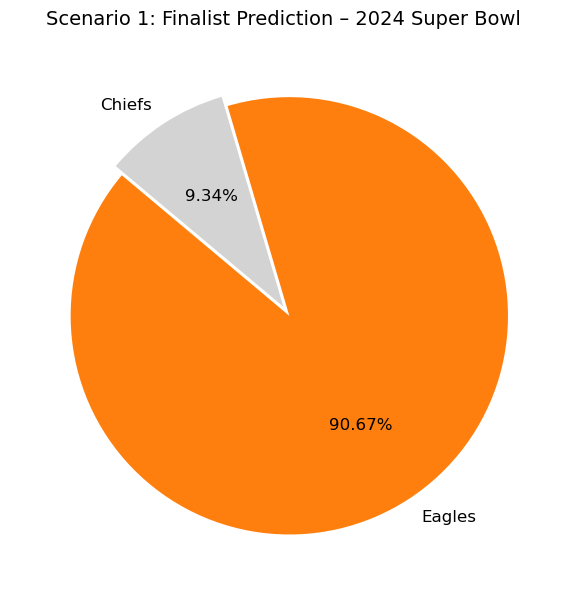

In [8]:
# Plot pie chart for Scenario 1 (2024 Super Bowl prediction)

plt.figure(figsize=(6, 6))
colors = ["#ff7f0e", "#d3d3d3"]
explode = (0.05, 0)

# Create pie chart
plt.pie(
    scenario1_champion_probs["Championship Probability (%)"],
    labels=scenario1_champion_probs["team"],
    autopct="%1.2f%%",
    startangle=140,
    colors=colors,
    explode=explode,
    textprops={'fontsize': 12}
)

plt.title("Scenario 1: Finalist Prediction – 2024 Super Bowl", fontsize=14)
plt.tight_layout()
plt.show()

SHAP for champion team: Eagles


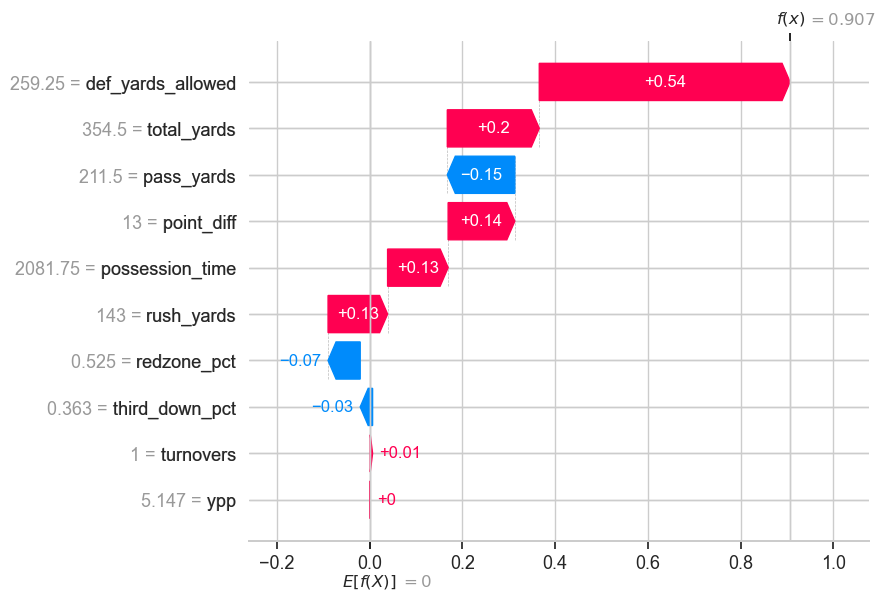

In [9]:
# Plots an adjusted SHAP waterfall chart for the predicted champion team in Scenario 1
def plot_shap_for_team(model, data, finalists_dict, season, window, champion_team, normalised_prob):

    # Load season data
    season_data = get_season_data_s1_and_s2(data, season, finalists_dict)

    # Drop metadata columns
    X = season_data.drop(columns=["team", "season", "week", "result", "is_champion"])
    features = X.columns
    teams = season_data["team"].values  # Team labels for grouping SHAP values

    # Compute SHAP values for each team-week observation
    explainer = shap.Explainer(model, X, model_output="probability")
    shap_values = explainer(X)

    # Build a SHAP DataFrame with corresponding team names
    shap_df = pd.DataFrame(shap_values.values, columns=features)
    shap_df["team"] = teams

    # Calculate the mean SHAP values for the champion team
    shap_row = shap_df[shap_df["team"] == champion_team][features].mean()

    # Compute the unnormalised model output
    raw_fx = shap_row.sum()

    # Calculate scaling factor to match normalised probability
    target_fx = normalised_prob
    scaling_factor = target_fx / raw_fx
    shap_row_scaled = shap_row * scaling_factor

    # Compute the mean input features for the champion team
    team_input_mean = X[season_data["team"] == champion_team].mean().values

    # Plot the adjusted SHAP waterfall chart
    print(f"SHAP for champion team: {champion_team}")
    sns.set(style="whitegrid")
    shap.plots.waterfall(
        shap.Explanation(
            values=shap_row_scaled.values,
            base_values=0,
            data=team_input_mean,
            feature_names=features
        )
    )
    
plot_shap_for_team(model_scenario1_2024_window2, data, finalists_dict, season=2024, window=2, champion_team="Eagles", normalised_prob=0.9066)

# Scenario 2:

In [10]:
# Filter results for 2024 season with 2-year training window
scenario2_results_2024 = scenario2_results[
    (scenario2_results['superbowl_year'] == 2024) &
    (scenario2_results['n_seasons_history'] == 2)
]

# Create DataFrame with model's predicted teams and their probabilities
scenario2_champion_probs = pd.DataFrame({
        "team": ast.literal_eval(scenario2_results_2024["team_names"].iloc[0]),
        "predicted_prob": ast.literal_eval(scenario2_results_2024["y_pred"].iloc[0])
})

# Convert probabilities to percentage format and round
scenario2_champion_probs["Championship Probability (%)"] = (
    scenario2_champion_probs["predicted_prob"] * 100
).astype(float).round(3)

# Display team names and probability percentages
scenario2_champion_probs[["team", "Championship Probability (%)"]]

,team,Championship Probability (%)
0,Eagles,19.781
1,Chargers,18.330
2,Packers,16.737
3,Vikings,9.911
4,Texans,8.632
5,Steelers,5.666
6,Broncos,5.228
7,Chiefs,4.556
8,Rams,4.402
9,Commanders,2.888


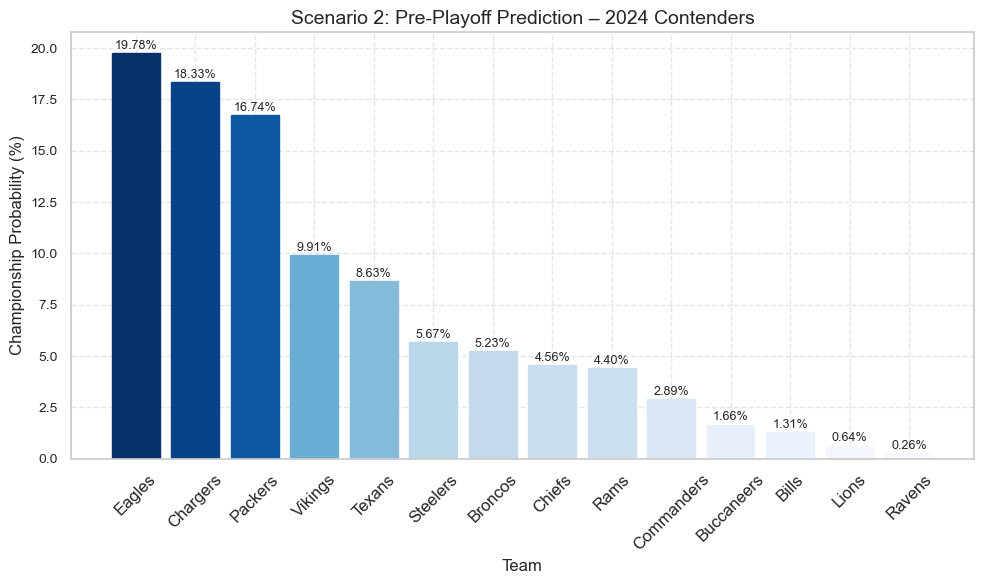

In [11]:
# Plot bar chart for Scenario 2 (2024 pre-playoff prediction)
plt.figure(figsize=(10, 6))

# Create bar plot of team probabilities
bars = plt.bar(scenario2_champion_probs["team"], scenario2_champion_probs["Championship Probability (%)"], edgecolor='black')

# Apply color shading based on height of each bar
for bar in bars:
    bar.set_color(plt.cm.Blues(bar.get_height() / max(scenario2_champion_probs["Championship Probability (%)"])))

plt.title("Scenario 2: Pre-Playoff Prediction – 2024 Contenders", fontsize=14)
plt.xlabel("Team", fontsize=12)
plt.ylabel("Championship Probability (%)", fontsize=12)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=10)
plt.grid(linestyle='--', alpha=0.5)

# Add value labels above each bar
for i, (team, prob) in enumerate(zip(scenario2_champion_probs["team"], scenario2_champion_probs["Championship Probability (%)"])):
    plt.text(i, prob + 0.2, f"{prob:.2f}%", ha='center', fontsize=9)

plt.tight_layout()
plt.show()

SHAP for champion team: Eagles


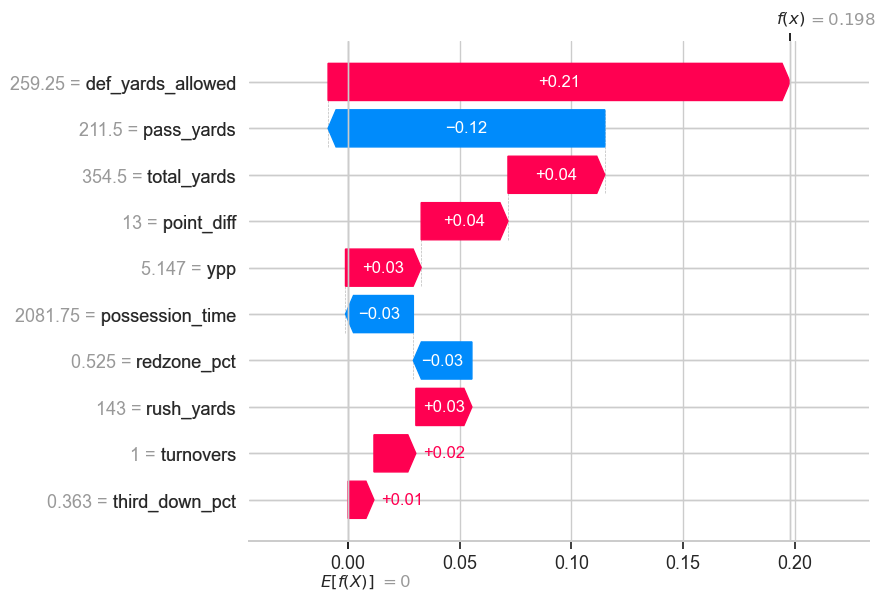

In [12]:
# Plots an adjusted SHAP waterfall chart for the predicted champion team in Scenario 2
def plot_shap_for_team(model, data, playoff_dict, season, window, champion_team, normalised_prob):

    # Load season data
    season_data = get_season_data_s1_and_s2(data, season, playoff_dict)

    # Drop metadata columns
    X = season_data.drop(columns=["team", "season", "week", "result", "is_champion"])
    features = X.columns
    teams = season_data["team"].values  # Team labels for grouping SHAP values

    # Compute SHAP values for each team-week observation
    explainer = shap.Explainer(model, X, model_output="probability")
    shap_values = explainer(X)

    # Build a SHAP DataFrame with corresponding team names
    shap_df = pd.DataFrame(shap_values.values, columns=features)
    shap_df["team"] = teams

    # Calculate the mean SHAP values for the champion team
    shap_row = shap_df[shap_df["team"] == champion_team][features].mean()

    # Compute the unnormalised model output
    raw_fx = shap_row.sum()

    # Calculate scaling factor to match normalised probability
    target_fx = normalised_prob
    scaling_factor = target_fx / raw_fx
    shap_row_scaled = shap_row * scaling_factor

    # Compute the mean input features for the champion team
    team_input_mean = X[season_data["team"] == champion_team].mean().values

    # Plot the adjusted SHAP waterfall chart
    print(f"SHAP for champion team: {champion_team}")
    shap.plots.waterfall(
        shap.Explanation(
            values=shap_row_scaled.values,
            base_values=0,
            data=team_input_mean,
            feature_names=features
        )
    )
    
plot_shap_for_team(model_scenario2_2024_window2, data, playoff_dict, season=2024, window=2, champion_team="Eagles", normalised_prob=0.1978)

# Scenario 3:

In [13]:
# Filter results for 2024 season with 4-year training window
scenario3_results_2024 = scenario3_results[
    (scenario3_results['superbowl_year'] == 2024) &
    (scenario3_results['n_seasons_history'] == 4)
]

# Create DataFrame with model's predicted teams and their probabilities
scenario3_champion_probs = pd.DataFrame({
        "team": ast.literal_eval(scenario3_results_2024["team_names"].iloc[0]),
        "predicted_prob": ast.literal_eval(scenario3_results_2024["y_pred"].iloc[0])
})

# Convert probabilities to percentage format and round
scenario3_champion_probs["Championship Probability (%)"] = (
    scenario3_champion_probs["predicted_prob"] * 100
).astype(float).round(3)

# Display team names and probability percentages
scenario3_champion_probs[["team", "Championship Probability (%)"]]

,team,Championship Probability (%)
0,Eagles,54.627
1,Raiders,10.230
2,Cowboys,9.862
3,Cardinals,6.525
4,Rams,3.912
5,Buccaneers,3.338
6,Ravens,2.092
7,Bengals,1.826
8,Giants,1.013
9,49ers,0.993


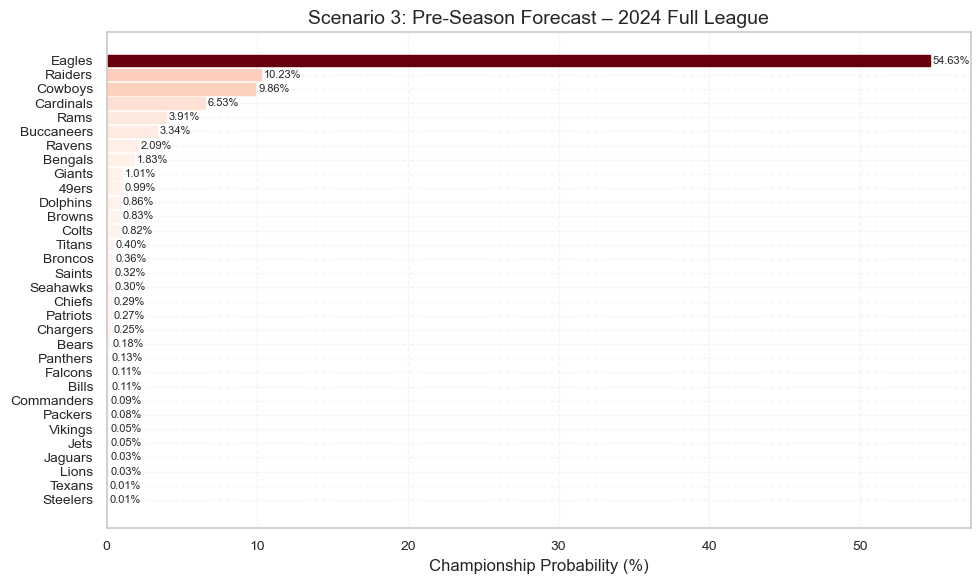

In [14]:
# Plots a horizontal bar chart of championship probabilities for top N teams
def plot_probs(results_df, title, top_n=32):
    # Select top N teams by probability
    results_2024 = results_df.nlargest(top_n, "Championship Probability (%)")

    # Create horizontal bar plot
    plt.figure(figsize=(10, 6))
    bars = plt.barh(results_2024["team"], results_2024["Championship Probability (%)"], edgecolor='black')

    # Apply color shading based on probability
    for bar in bars:
        bar.set_color(plt.cm.Reds(bar.get_width() / max(results_2024["Championship Probability (%)"])))

    # Invert y-axis to have highest probability team at the top
    plt.gca().invert_yaxis()
    
    plt.title(title, fontsize=14)
    plt.xlabel("Championship Probability (%)", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(linestyle='--', alpha=0.2)

    # Add value labels at the end of each bar
    for i, (prob) in enumerate(results_2024["Championship Probability (%)"]):
        plt.text(prob + 0.2, i, f"{prob:.2f}%", va='center', fontsize=8)

    plt.tight_layout()
    plt.show()

plot_probs(scenario3_champion_probs, title="Scenario 3: Pre-Season Forecast – 2024 Full League")

SHAP for champion team: Eagles


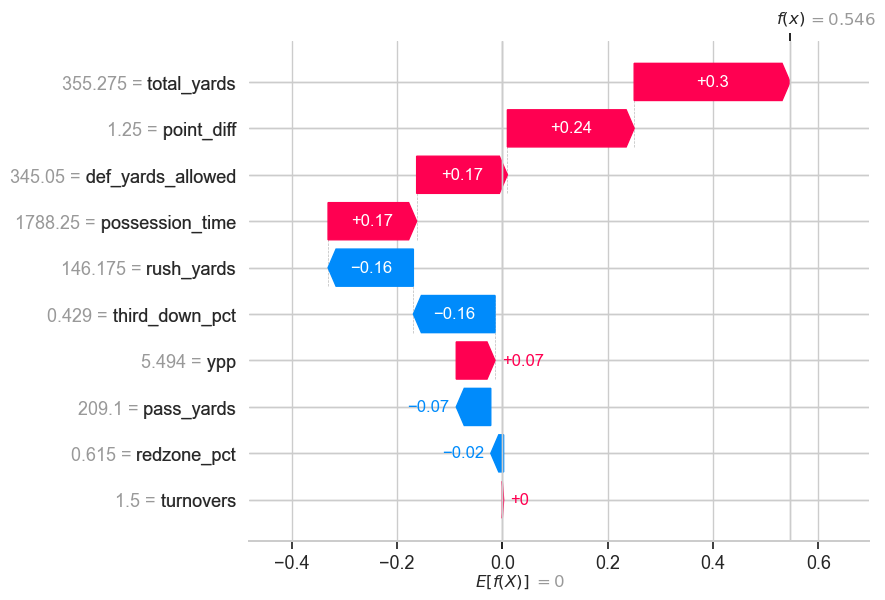

In [15]:
# Plots an adjusted SHAP waterfall chart for the predicted champion team in Scenario 3
def plot_combined_shap_for_team(playoff_model, champion_model, data, season, window, champion_team, normalised_prob):

    # Load season data
    season_data =get_season_data_s3(data, season, window)

    # Drop metadata columns
    X = season_data.drop(columns=["team"])
    features = X.columns
    teams = season_data["team"].values  # Team labels for grouping SHAP values

    # پیش‌بینی احتمال‌ها
    f1 = playoff_model.predict_proba(X)[:, 1]
    f2 = champion_model.predict_proba(X)[:, 1]
    
    # Compute SHAP values
    explainer1 = shap.Explainer(playoff_model, X, model_output="probability")
    shap1 = explainer1(X).values
    explainer2 = shap.Explainer(champion_model, X, model_output="probability")
    shap2 = explainer2(X).values

    # ترکیب SHAPها
    shap_combined_all = shap1 * f2[:, np.newaxis] + shap2 * f1[:, np.newaxis]

    # Build a SHAP DataFrame with corresponding team names
    shap_df = pd.DataFrame(shap_combined_all, columns=features)
    shap_df["team"] = teams
    shap_df["prob"] = f1 * f2

    # استخراج SHAP for the champion team
    shap_row = shap_df[shap_df["team"] == champion_team][features].values.flatten()

    # Compute the unnormalised model output
    raw_fx = shap_row.sum()

    # Calculate scaling factor to match normalised probability
    target_fx = normalised_prob
    scaling_factor = target_fx / raw_fx
    shap_row_scaled = shap_row * scaling_factor

    # the input features for the champion team
    team_input = X[season_data["team"] == champion_team].iloc[0].values

    # Plot the adjusted SHAP waterfall chart
    print(f"SHAP for champion team: {champion_team}")
    shap.plots.waterfall(
        shap.Explanation(
            values=shap_row_scaled,
            base_values=0,
            data=team_input,
            feature_names=features
        )
    )

plot_combined_shap_for_team(
    playoff_model_scenario3_2024_window4, champion_model_scenario3_2024_window4, data,
    season=2024, window=4, champion_team="Eagles", normalised_prob=0.5463
)